# Detecting Sarcasm in News Headlines
### Jane Downer<br><br>



---



---



<br>

### This dataset comes from [Kaggle](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection). Each entry in the data includes a headline, each of which is pre-labeled as sarcastic (1) or not sarcastic (1). All of the sarcastic headlines come from The Onion, and all of the not-sarcastic headlines come from Huffington Post. There are a total of 28619 entries.

## READ FIRST:

1. My conclusions are included throughout the file rather than all at the end.
2. ***Warning***: There is a cell in this code that took my computer 23 minutes to complete. I have flagged the cell. I also included the output returned by the cell, in case you want to just observe the output rather than actually run that particular piece of code.

In [2]:
%%capture
import itertools
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, average_precision_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import tqdm
from tqdm import tqdm
import json
from google.colab import files
!pip install pipelinehelper
import pipelinehelper
from pipelinehelper import PipelineHelper


In [3]:
uploaded = files.upload()

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2.json


# Data exploration

## A first look

In [4]:
raw_data = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines = True)
raw_data['label'] = raw_data['is_sarcastic'].map({1:'sarcastic',0:'not sarcastic'})
data = raw_data.drop(columns = ['article_link'])
data.head()

,is_sarcastic,headline,label
0,1,thirtysomething scientists unveil doomsday clo...,sarcastic
1,0,dem rep. totally nails why congress is falling...,not sarcastic
2,0,eat your veggies: 9 deliciously different recipes,not sarcastic
3,1,inclement weather prevents liar from getting t...,sarcastic
4,1,mother comes pretty close to using word 'strea...,sarcastic


## Shape & Size



------------------------------------
------------- Null Data ------------
------------------------------------



is_sarcastic    0
headline        0
label           0
dtype: int64



------------------------------------
------------ Data Shape ------------
------------------------------------



(28619, 3)



------------------------------------
------ Distribution of labels ------
------------------------------------



not sarcastic    14985
sarcastic        13634
Name: label, dtype: int64



------------------------------------
-- Headline Lengths (#Characters) --
------------------------------------



count    28619.000000
mean        62.308571
std         20.726483
min          7.000000
25%         49.000000
50%         62.000000
75%         75.000000
max        926.000000
Name: length, dtype: float64

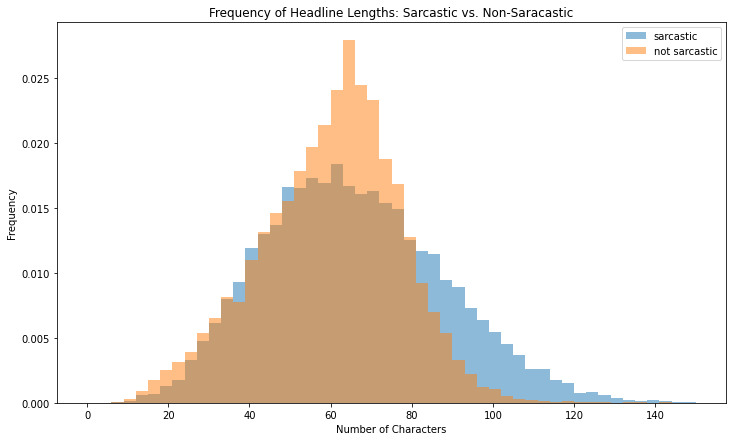

In [5]:
print("\n\n------------------------------------")
print("------------- Null Data ------------")
print("------------------------------------\n")

display(data.isnull().sum())

print("\n\n------------------------------------")
print("------------ Data Shape ------------")
print("------------------------------------\n")
display(data.shape)
print("\n\n------------------------------------")
print("------ Distribution of labels ------")
print("------------------------------------\n")
display(data.label.value_counts())

print("\n\n------------------------------------")
print("-- Headline Lengths (#Characters) --")
print("------------------------------------\n")
data['length'] = data['headline'].apply(len)
display(data['length'].describe())
print("\n\n")

###################################################

d_sar = data[data['label']=='sarcastic']
d_nsar = data[data['label']=='not sarcastic']

plt.figure(figsize=(12,7))
plt.hist(d_sar['length'], bins=50, alpha=0.5, label="sarcastic", range=(0,150),density = True)
plt.hist(d_nsar['length'], bins=50, alpha=0.5, label="not sarcastic", range = (0,150), density = True)
plt.xlabel("Number of Characters")
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title("Frequency of Headline Lengths: Sarcastic vs. Non-Saracastic")
plt.show()

### The data is somewhat evenly split between 'sarcastic' and 'non-sarcastic' headlines. The sarcastic headlines have lengths that are more spread out than the non-sarcastic headlines, and are more inclined than non-sarcastic headlines to have a large number of characters. The non-sarcastic headlines are more concentrated around a central value.

# Pre-Processing

# Steps:
### 1.   Replace contracted words
### 2.   Remove non-alphabetic characters
### 3.   Basic tokenization
### 4.   Remove stopwords
### 5.   Lemmatization & Stemming




In [6]:
# replace contracted words
def decontracted(phrase):
    regex_dict = {"won't": "will not",  "n\'t": " not",  "\'m": " am",    "\'d": " would", "[ ]\'s": " s",
                  "can\'t": "can not",   "\'re": " are",  "\'t": " not",  "\'ll": " will",    "\'ve": " have",
                  "[a-zA-Z]\'s": " is", "-(?:(?<!\b[0-9]{4}-)|(?![0-9]{2}(?:[0-9]{2})?\b))": ' '}
    regex = re.compile("(%s)" % "|".join(map(re.escape, regex_dict.keys())))
    return regex.sub(lambda s: regex_dict[s.string[s.start():s.end()]], phrase) 
# remove non-alphabetic characters
def only_alpha(phrase):
  phrase = re.sub("[^a-zA-Z ]","", phrase)
  return phrase
# remove punctuation
def remove_punc(phrase):
  phrase = phrase.translate(str.maketrans('', '', string.punctuation))
  return phrase
####################################################################
# combine above functions
def clean_text(df):
  cleaned_headline = []
  for h in df['headline']:
    h = remove_punc(only_alpha(decontracted(h))) # expand contracted words
    cleaned_headline.append(h)
  return cleaned_headline
####################################################################
en_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer(language='english')

# Original
original = [headline for headline in data['headline']]
# Cleaned
cleaned = clean_text(data)
# Basic Tokenization
basic_tok = [word_tokenize(headline) for headline in cleaned]   
# Stopword Removal                        
no_stop = [[word for word in entry if not word.lower() in en_stopwords] for entry in basic_tok]  
# Lemmatization
lemmatized = [[lemmatizer.lemmatize(word) for word in entry] for entry in no_stop]  
# Stemming              
stemmed = [[stemmer.stem(word) for word in entry] for entry in lemmatized]    

print('\"' + original[24] + '\"','                         << original')
print('\"' + cleaned[24] + '\"','                            << cleaned')
print(basic_tok[24], "  << tokenization")
print(no_stop[24], "               << no stopwords")
print(lemmatized[24], "                 << no stopwords + lemmatization")
print(stemmed[24], "                      << no + lemmatization + stemming")

"bill clinton shoots down republicans: 'i strongly supported' obamacare"                          << original
"bill clinton shoots down republicans i strongly supported obamacare"                             << cleaned
['bill', 'clinton', 'shoots', 'down', 'republicans', 'i', 'strongly', 'supported', 'obamacare']   << tokenization
['bill', 'clinton', 'shoots', 'republicans', 'strongly', 'supported', 'obamacare']                << no stopwords
['bill', 'clinton', 'shoot', 'republican', 'strongly', 'supported', 'obamacare']                  << no stopwords + lemmatization
['bill', 'clinton', 'shoot', 'republican', 'strong', 'support', 'obamacar']                       << no + lemmatization + stemming


## Let's pause to observe the distribution of tokens/words in our dataset.

### i. Lexical Diversity

In [7]:
def create_text(tokens):
  text = []
  for entry in tokens:
    for word in entry:
      text.append(word)
  return(text)

def getData_and_plot(txt, df):
  vocabulary = sorted(set([word.lower() for word in txt]))
  n_tokens, n_sents, n_types = len(txt), len(df), len(vocabulary)
  lexical_diversity = n_types/n_tokens
  data_info = []
  data_info.append({'tokens': n_tokens, 'vocab': n_types,'lexical diversity':"%.3f" % lexical_diversity, 'average sentence length': "%.3f" % (n_tokens/n_sents), 'average word frequency': "%.3f" % (n_tokens/n_types)})  
  display(pd.DataFrame(data_info))

text1 = create_text(basic_tok)
text2 = create_text(stemmed)

getData_and_plot(text1, data)
print('')
getData_and_plot(text2, data)

,tokens,vocab,lexical diversity,average sentence length,average word frequency
0,285296,29054,0.102,9.969,9.820


,tokens,vocab,lexical diversity,average sentence length,average word frequency
0,203247,19769,0.097,7.102,10.281


### ii. Zipf's Law holds up (mostly)

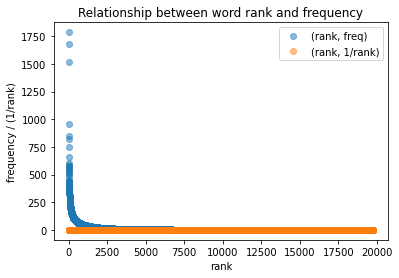

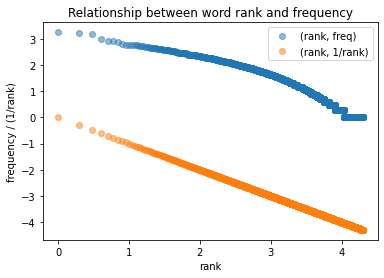

In [8]:
#########################################################
def flatten(lst_of_lsts):
  items = []
  for lst in lst_of_lsts:
    for thing in lst:
      items.append(thing)
  return items
#########################################################
def display_freq_words(which_tokens, topn):
    allWds = flatten(which_tokens)
    wdFreq = nltk.FreqDist(w.lower() for w in allWds)
    wdFreq_sorted = sorted(wdFreq.items(),key=lambda item: item[1], reverse=True)
    wfreq_topn = wdFreq_sorted[:topn] 
    df_topn = pd.DataFrame({'word':      [w for w, f in wfreq_topn],
                            'frequency': [f for w, f in wfreq_topn],
                            'rank':      range(1,len(wfreq_topn)+1) })
    df_topn['frequency*rank'] = df_topn['frequency']*df_topn['rank']
    return df_topn
#########################################################
text = stemmed
df_topn = display_freq_words(text, -1)
x = df_topn['rank'].values
[y1, y2] = [df_topn['frequency'].values, [1/v for v in df_topn['rank'].values]]

for [x_data, y_data] in ([x, [y1, y2]],
                         [np.log10(x), [np.log10(y1), np.log10(y2)]]):
  plt.figsize=(20,10)
  plt.plot(x_data, y_data[0], 'o', label='(rank, freq)',alpha=0.5)
  plt.plot(x_data, y_data[1], 'o', label='(rank, 1/rank)',alpha=0.5)
  plt.xlabel('rank')
  plt.ylabel('frequency / (1/rank)')
  plt.title("Relationship between word rank and frequency")
  plt.legend()
  plt.show()

### Zipf's Law seems to mostly hold up with this data. The logarithmic plot of rank versus frequency shows some slight curvature, although this only appeared after heavy pre-processing.

### iii. Most frequent words

In [9]:
[t1,t2] = [[t for t in toks] for toks in [basic_tok, stemmed]]
l1,l2 = [len(np.unique(flatten(toks))) for toks in [t1,t2]]

input =[['all tokens', t1, l1],
        ['no stopwords + lemmatized + stemmed', t2, l2]]

for [name, list_, length] in input:
  print('Top 10 words in vocabulary (' + name + '):\n')
  print(display_freq_words(list_, 10))
  print('\nNumber of unique tokens:',length,'\n\n\n')

Top 10 words in vocabulary (all tokens):

   word  frequency  rank  frequency*rank
0    to       9052     1            9052
1    of       6263     2           12526
2   the       5294     3           15882
3    in       4540     4           18160
4   for       3625     5           18125
5     a       3109     6           18654
6    on       2627     7           18389
7   and       1982     8           15856
8   not       1972     9           17748
9  with       1955    10           19550

Number of unique tokens: 29054 



Top 10 words in vocabulary (no stopwords + lemmatized + stemmed):

     word  frequency  rank  frequency*rank
0   trump       1786     1            1786
1     new       1677     2            3354
2     man       1515     3            4545
3   woman        959     4            3836
4     get        848     5            4240
5  report        819     6            4914
6     say        748     7            5236
7    make        658     8            5264
8       u        

### Before pre-processing, the most frequent words in the dataset were stopwords. The second list is more reflective of the topics covered in the headlines.

# Vectorization & Classification<br>
### (example: TfidfVectorizer, Logistic Regression)

In [10]:
from nltk.util import ngrams

headlines = [' '.join(headline) for headline in text]
corpus1 = ' '.join(headlines)

vectorizer1 = CountVectorizer()
vectorizer2 = TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False, ngram_range = (1,2))

X1 = vectorizer1.fit_transform(headlines) # Learn the vocabulary dictionary and return document-term matrix
X2 = vectorizer2.fit_transform(headlines)
print(X1.toarray())

token = nltk.word_tokenize(corpus1)
unigrams = ngrams(token,1)
bigrams = ngrams(token,2)
fdist_uni = nltk.FreqDist(unigrams)
fdist_bi = nltk.FreqDist(bigrams)


sorted_uni = sorted((fdist_uni).items(),key=lambda item: item[1], reverse=True)
sorted_bi = sorted((fdist_bi).items(),key=lambda item: item[1], reverse=True)

print('\nFeature names: ' + str(list(fdist_uni.keys())[:10]))       # Array mapping from feature integer indices to feature name
print('Top features: ' + (str(sorted_uni))[0:92] + ' ...}\n\n')  # A mapping from terms to feature indices
print('\nFeature names: ' + str(list(fdist_bi.keys())[:10]))       # Array mapping from feature integer indices to feature name
print('Top features:' + (str(sorted_bi))[0:98] + ' ...}')  # A mapping from terms to feature indices

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Feature names: [('thirtysometh',), ('scientist',), ('unveil',), ('doomsday',), ('clock',), ('hair',), ('loss',), ('dem',), ('rep',), ('total',)]
Top features: [(('trump',), 1786), (('new',), 1677), (('man',), 1515), (('woman',), 959), (('get',), 848), ...}



Feature names: [('thirtysometh', 'scientist'), ('scientist', 'unveil'), ('unveil', 'doomsday'), ('doomsday', 'clock'), ('clock', 'hair'), ('hair', 'loss'), ('loss', 'dem'), ('dem', 'rep'), ('rep', 'total'), ('total', 'nail')]
Top features:[(('donald', 'trump'), 460), (('area', 'man'), 263), (('white', 'hous'), 212), (('hillari', 'clint ...}


### A few of the most frequent unigrams appear in the list of most frequent bigrams, such as with "donald trump" and "area man". The bigrams give a bit more context to the topics being discussed.

## Run Classifier (example: Logistic Regression)

In [11]:
def run_classifier(vectorizer, clf, headlines, y):
  X = vectorizer.fit_transform(headlines)
  # train-test split:
  trn_i, tst_i = train_test_split(np.arange(data.shape[0]), test_size=0.2, shuffle=True, random_state=42)
  data_train, data_test = data.iloc[trn_i], data.iloc[tst_i]
  X_trn, y_trn, X_tst, y_tst = X[trn_i], y[trn_i], X[tst_i], y[tst_i]
  clf.fit(X_trn, y_trn)
  # make prediction on testing data
  y_pred_test = clf.predict(X_tst)
  y_predprob_test = clf.predict_proba(X_tst)
  return [clf, X_trn, y_trn, X_tst, y_tst, y_pred_test, y_predprob_test, data_train, data_test]

v1 = TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
c1 = LogisticRegression(max_iter = 1000)
y_ = data.is_sarcastic.values
headlines1 = headlines
results1 = run_classifier (v1, c1, headlines1, y_)
print(classification_report(results1[4],results1[5]))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2995
           1       0.79      0.75      0.77      2729

    accuracy                           0.79      5724
   macro avg       0.79      0.78      0.79      5724
weighted avg       0.79      0.79      0.79      5724



### Accuracy comes out at about 79%, which is ok. Let's use cross-validation to assess whether this can be consistently expected.

## Cross-validation

In [12]:
scores = cross_val_score(c1, v1.fit_transform(headlines1), y_, cv=5, scoring='accuracy')
print(scores)

[0.78144654 0.78336827 0.79105521 0.78983229 0.78927136]


### Cross-validation produces accuracy scores that consistently fall between about 78% and 79%.

## ROC Curve

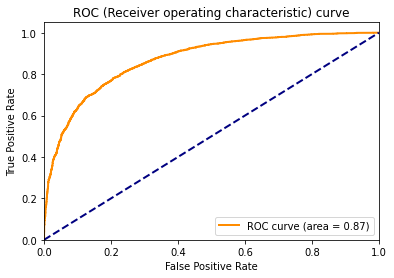

In [13]:
def plot_roc (results):
  y_t, y_s = results[4], results[6][:,1]
  fpr, tpr, thresholds = roc_curve(y_true = y_t, y_score = y_s, pos_label=1)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC (Receiver operating characteristic) curve')
  plt.legend(loc="lower right")
  plt.show()

plot_roc(results1)

### The ROC curve shows that the model is able to achieve a true positive rate of about 80% before the false positive rate rises above 20%. In a perfect model, the orange curve would be pulled up to the upper left-hand corner. However, this model is significantly better than one with no predictive power, which would correspond to the blue diagonal line.

## Precision-recall curve

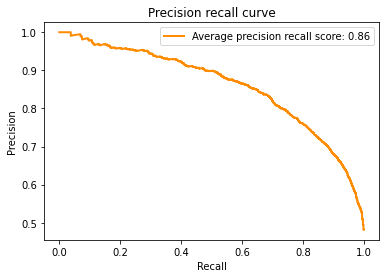

In [14]:
def plot_prec_rec(results):
  y_t = results[4]
  y_s = results[6][:,1]
  precision, recall, thresholds = precision_recall_curve(y_true=y_t, probas_pred=y_s, pos_label=1)
  lw = 2
  plt.plot(recall, precision, color='darkorange', lw=lw,
          label='Average precision recall score: %0.2f' % average_precision_score(y_t, y_s))
  plt.title('Precision recall curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

plot_prec_rec(results1)

### The precision-recall curve reflects the findings in the ROC curve, showing that the model can attain both relatively high precision and relatively high recall. (I.e., not perfect, but better than totally random.)

## Confusion Matrix

In [15]:
%%capture
from sklearn.metrics import plot_confusion_matrix
v = v1
c = c1
headlines = headlines1
y_ = data.is_sarcastic.values
results = run_classifier (v, c, headlines, y_)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(c, results[3], results[4],
                                 display_labels=['Not Sarcastic','Sarcastic'],
                                 cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

normalized_cm = disp.confusion_matrix

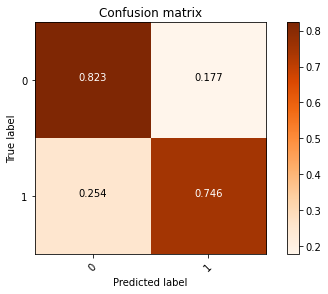

In [128]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges, normalize = 'true'):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()%2).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.3f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = normalized_cm
np.set_printoptions(precision=1) 
fig, ax = plt.subplots()
plot_confusion_matrix(cm)
plt.show()

### The confusion mtrix shows a true positive rate of about 75%, a true negative rate of about 82%, a false negative rate of about 25%, and a false positive rate of about 18%. The false negative rate is higher than I would like it to be.

In [16]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(v.get_feature_names(), c.coef_[0])}
print("\nTop \'sarcastic\' features:")
for x in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]:
  print(x)
print("\nTop \'non-sarcastic\'' features:")
for x in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]:
  print(x)


Top 'sarcastic' features:
('area', 6.775)
('man', 6.02)
('nation', 5.097)
('fuck', 4.844)
('report', 4.454)
('local', 4.156)
('announc', 3.773)
('studi', 3.756)
('introduc', 3.754)
('shit', 3.311)

Top 'non-sarcastic'' features:
('donald', -4.731)
('here', -4.546)
('trump', -4.369)
('tweet', -3.135)
('california', -2.898)
('hillari', -2.898)
('muslim', -2.703)
('queer', -2.612)
('tran', -2.539)
('transgend', -2.527)


### The top 10 sarcastic features include 2 curse words, which makes sense, since these words are much more likely to appear in a humorous setting. The non-sarcastic features have a significant number of proper nouns -- Trump, California, and Hillar(y), for example -- as well as a significant number of references to specific groups of people -- Muslim, Queer, and Transgender. These tend to be more serious topics, and are less likely to appear in humorous settings.

# Improvements: Grid Search

### To search for ways to improve the model, I ran a Grid Search on two different vectorizers, three different classifiers, and several options for parameters corresponding to each of these. The results show the combination of choices that produced the highest accuracy scores.

### ------------------------------------------------------------------------------
### **Warning**: this next cell took my computer 23 minutes to complete. If you would like to skip this cell and just get the output that it returns, I've pasted the output in the cell after this one.
### ------------------------------------------------------------------------------


In [19]:
# pipe = Pipeline([
#                  ('vectorizer', PipelineHelper([
#                      ('v1', CountVectorizer(ngram_range=(1,2))),
#                      ('v2', TfidfVectorizer(ngram_range=(1,2)))
#                  ])),
#                  ('classifier', PipelineHelper([
#                      ('svm', LinearSVC(max_iter=1000)),
#                      ('lr', LogisticRegression(max_iter=1000)),
#                      ('nb', MultinomialNB())
#                  ])),
#                 ])

# param_grid = {
#               'vectorizer__selected_model': pipe.named_steps['vectorizer'].generate({
#                   'v1__min_df': [1, 3, 5, 10],
#                   'v1__max_df': [0.7, 0.8, 0.9],
#                   'v2__min_df': [1, 3, 5, 10],
#                   'v2__max_df': [0.7, 0.8, 0.9]
#                }),
#               'classifier__selected_model': pipe.named_steps['classifier'].generate({
#                   'lr__solver': ['lbfgs', 'sag', 'saga'],
#                   'svm__C': [0.1, 1.0]
#                })
#               }


# grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy').fit(headlines1, data.is_sarcastic.values)
# print(grid.best_params_)
# print(grid.best_score_)

{'classifier__selected_model': ('svm', {'C': 1.0}), 'vectorizer__selected_model': ('v2', {'max_df': 0.7, 'min_df': 1})}
0.8043958670574544


In [21]:
output = "{'classifier__selected_model': ('svm', {'C': 1.0}), 'vectorizer__selected_model': ('v2', {'max_df': 0.7, 'min_df': 1})}"
acc = 0.8043958670574544

### The results of the Grid Search suggest that we use the LinearSVC classifier and TfidfVectorizer, with the parameters suggested in parentheses in the output.

### Let's try it again using the suggested parameters:

In [22]:
from sklearn.calibration import CalibratedClassifierCV
v = TfidfVectorizer(ngram_range=(1,2), min_df = 1, max_df = 0.7)
c = CalibratedClassifierCV(LinearSVC(max_iter=1000, C = 1.0))
headlines = headlines1
y_ = data.is_sarcastic.values
results2 = run_classifier(v, c, headlines, y_)
print(classification_report(results2[4],results2[5]))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2995
           1       0.80      0.78      0.79      2729

    accuracy                           0.80      5724
   macro avg       0.80      0.80      0.80      5724
weighted avg       0.80      0.80      0.80      5724



### These suggestions brought accuracy from 79% to 80%, which isn't nothing, but it also isn't a lot. I'm going to try another way to improve the model.

### Pre-processing consisted of 5 steps. I'm going to see how the inclusion or exclusion of each of these steps affects the acccuracy of the model.

In [23]:
## Find all possible ways to tokenize the data given the parameters remove_stop, lemm, stem
def tweak_tokens(df, remove_stop = False, lemm = False, stem = False):
  og_toks = [word_tokenize(headline) for headline in cleaned]
  toks = []
  if remove_stop == True:
    for entry in og_toks:
      toks.append([word for word in entry if not word.lower() in en_stopwords])
  else:
    toks = og_toks
  if lemm == True:
    toks_copy = toks
    toks = [[lemmatizer.lemmatize(word) for word in entry] for entry in toks_copy]
  else:
    pass
  if stem == True:
    toks_copy = toks
    toks = [[stemmer.stem(word) for word in entry] for entry in toks_copy]
  else:
    pass
  return toks
###########
## Find all possible lists of tokens given choices to remove stopwords, lemmatize, and stem
tf_combos = [list(item) for item in [element for element in itertools.product([True, False],[True, False],[True, False])]]
ts = []
length = len(tf_combos)
pbar = tqdm(total=length)
for i in range(length):
    t = tweak_tokens(data, tf_combos[i][0], tf_combos[i][1], tf_combos[i][2])
    ts.append(t)
    pbar.update(1)
pbar.close()

100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


In [51]:
##########
v = TfidfVectorizer(ngram_range=(1,2))
c = CalibratedClassifierCV(LinearSVC(max_iter=1000, C = 1.0))
corpii = [[' '.join(headline) for headline in t] for t in ts]
corpus_params = [''.join(list(x)) for x in itertools.product(["remove_stop = "],["True", "False"],[", lemm = "],["True", "False"],[", stem = "],["True", "False"])]
###########

reports = []
score_lst = []
corp_param_lst = []

length = len(corpii)
pbar = tqdm(total=length)
for k in range(length):
  corpus = corpii[k]
  results = run_classifier(v, c, corpus, data.is_sarcastic)
  rep = classification_report(results[4],results[5])
  scores = [float(s) for s in word_tokenize(rep)[25:-1]]
  avg_score = sum(scores)/3
  score_lst.append(round(avg_score,4))
  corp_param_lst.append(corpus_params[k])
  reports.append(rep)
  pbar.update(1)
pbar.close()

compare_params = pd.DataFrame({'Average Score': score_lst, 'Tokenization Decisions': corp_param_lst})
compare_params = compare_params.sort_values(by=['Average Score'], ascending=False).reset_index(drop=True)
print('')
compare_params

100%|██████████| 8/8 [00:18<00:00,  2.33s/it]

,Average Score,Tokenization Decisions
0,0.85,"remove_stop = False, lemm = True, stem = True"
1,0.85,"remove_stop = False, lemm = True, stem = False"
2,0.85,"remove_stop = False, lemm = False, stem = True"
3,0.85,"remove_stop = False, lemm = False, stem = False"
4,0.81,"remove_stop = True, lemm = True, stem = False"
5,0.81,"remove_stop = True, lemm = False, stem = False"
6,0.80,"remove_stop = True, lemm = True, stem = True"
7,0.80,"remove_stop = True, lemm = False, stem = True"


### We can see from the results that the following tokenization decisions yield the most accurate results:
#### 1. [remove_stop = False, lemm = True, stem = True]
#### 2. [remove_stop = False, lemm = True, stem = False]
#### 3. [remove_stop = False, lemm = False, stem = True]<br>
### This suggests that the classification is most successful when we do not remove stopwords. Maybe the stopwords provide context?<br>
### Moreover, choosing either lemmatization, stemming, or both lemmatization and stemming doesn't affect accuracy -- regardless of the choice, the accuracy score stays at about 85%.<br>
###What if we try to make the lemmatization more useful? Let's perform lemmatization on the headlines *with* the stopwords still present, and provide the lemmatizer parts of speech for more context, which may improve its effectiveness.

In [24]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatizer_with_pos(sentence):
  pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
      if tag is None:
          lemmatized_sentence.append(word)
      else:        
          lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  lemmatized_sentence = " ".join(lemmatized_sentence)
  return lemmatized_sentence


headlines2 = []
for i in range(len(cleaned)):
    s = lemmatizer_with_pos(cleaned[i])
    headlines2.append(s)

In [25]:
print(headlines1[8])
print(headlines2[8])

shadow govern get larg meet marriott confer room b
shadow government get too large to meet in marriott conference room b


### The two lines above show the same headline, the first with the original pre-processing method and the second with the new pre-processing method. One thing I notice is that the first method converted the words "government" and "conference" to shorter words that have different meanings, which isn't desirable.

In [26]:
# Test out the classifier using GridSearch suggestions + new corpus
##########
v = TfidfVectorizer(ngram_range=(1,2), min_df = 1, max_df = 0.7)
c = CalibratedClassifierCV(LinearSVC(max_iter=1000, C = 1.0))
headlines = headlines2
y_ = data.is_sarcastic.values
###########
results2 = run_classifier(v, c, headlines2, y_)
print(classification_report(results2[4],results2[5]))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2995
           1       0.84      0.85      0.85      2729

    accuracy                           0.85      5724
   macro avg       0.85      0.85      0.85      5724
weighted avg       0.85      0.85      0.85      5724



### Accuracy remains at 85%. So while we can conclude that the inclusion of stopwords did significantly improve accuracy (from 80% to 85%), the modified lemmatizer didn't have any substantial effect.

In [27]:
%%capture
from sklearn.metrics import plot_confusion_matrix


results = results2

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(c, results[3], results[4],
                                 display_labels=['Not Sarcastic','Sarcastic'],
                                 cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

normalized_cm = disp.confusion_matrix

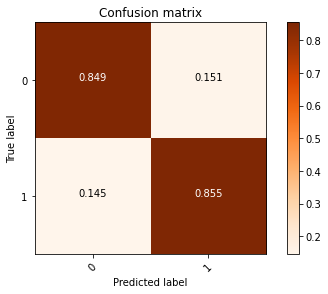

In [39]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges, normalize = 'true'):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()%2).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.3f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = normalized_cm
np.set_printoptions(precision=1) 
fig, ax = plt.subplots()
plot_confusion_matrix(cm)
plt.show()

### True positive and True negative rates are 85.5% and 84.9%, rspectively. False positive and false negative rates are both around 15%. Remember that previously, the false negative rate was around 25%, so this is a significant improvement.

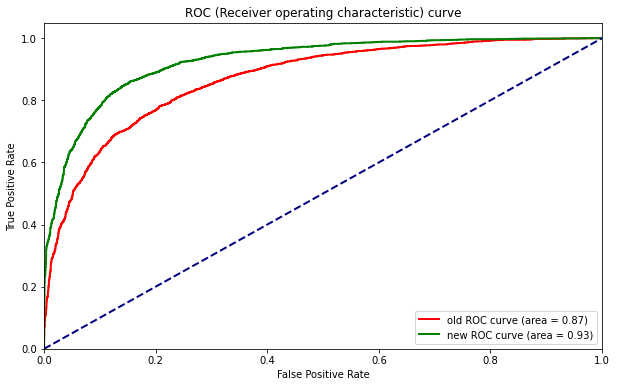

In [29]:
# Let's compare this to the old results.
y_t_1, y_s_1 = results1[4], results1[6][:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_true = y_t_1, y_score = y_s_1, pos_label=1)

y_t_2, y_s_2 = results2[4], results2[6][:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_true = y_t_2, y_score = y_s_2, pos_label=1)

roc_auc_1, roc_auc_2 = auc(fpr1, tpr1), auc(fpr2, tpr2)
lw=2
plt.figure(figsize=(10,6))
plt.plot(fpr1, tpr1, color='red', lw=2, label='old ROC curve (area = %0.2f)' % roc_auc_1)
plt.plot(fpr2, tpr2, color='green', lw=2, label='new ROC curve (area = %0.2f)' % roc_auc_2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver operating characteristic) curve')
plt.legend(loc="lower right")
plt.show()

The modified model's ROC curve (in green) is getting closer to that upper left-hand corner, which implies more accuracy. The area under the curve also increased from 0.87 to 0.93.

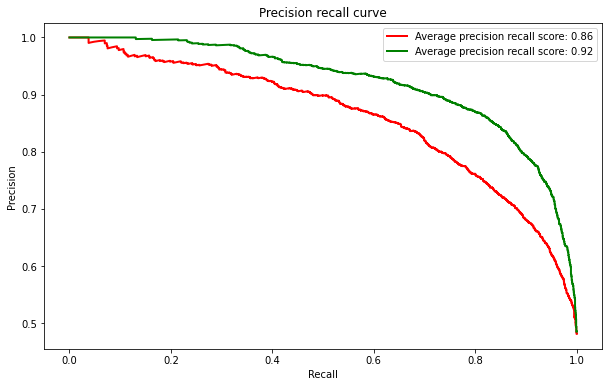

In [30]:
y_t_1_, y_s_1_ = results1[4], results1[6][:,1]
precision1, recall1, thresholds1 = precision_recall_curve(y_true = y_t_1_, probas_pred=y_s_1_, pos_label=1)
y_t_2_, y_s_2_ = results2[4], results2[6][:,1]
precision2, recall2, thresholds2 = precision_recall_curve(y_true = y_t_2_, probas_pred=y_s_2_, pos_label=1)

plt.figure(figsize=(10,6))
plt.plot(recall1, precision1, color='red', lw=2,
        label='Average precision recall score: %0.2f' % average_precision_score(y_t_1, y_s_1_))
plt.plot(recall2, precision2, color='green', lw=2,
        label='Average precision recall score: %0.2f' % average_precision_score(y_t_2, y_s_2_))
plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


### The new model's precision-recall curve shows similar improvement, with the new model's curve (in green) getting closer to the upper right-hand corner. The average precision recall score also increased from 0.86 to 0.92.

### Let's see the features of the new model.

In [35]:
%%capture
from sklearn.calibration import CalibratedClassifierCV
v3 = TfidfVectorizer(ngram_range=(1,2), min_df = 1, max_df = 0.7)
c3 = CalibratedClassifierCV(LinearSVC(max_iter=1000, C = 1.0))
y = data.is_sarcastic.values

v3 = TfidfVectorizer(ngram_range=(1,2))
c3 = CalibratedClassifierCV(LinearSVC(max_iter=1000, C = 1.0))
y_ = data.is_sarcastic.values

results_3 =   run_classifier(v3, c3, headlines2, y)
clf = results_3[0]
y_pred_test = results_3[5]
data_test = results_3[8]
cs = [c_1, c_2, c_3, c_4, c_5] = clf.calibrated_classifiers_

In [36]:
coefs_ = []
for c_ in cs:
  c = c_.base_estimator
  word_coef_dict = dict({word: float("%.3f" % coef) for word, coef in zip(v3.get_feature_names(), c.coef_[0])})
  coef_ = list(word_coef_dict.values())
  coefs_.append(coef_)

avg_coefs = []
for i in range((len(coefs_[0]))):
  avg_coef = sum([coefs_[0][i], coefs_[1][i], coefs_[2][i], coefs_[3][i], coefs_[4][i]])/5
  avg_coefs.append(avg_coef)
new_dict = dict({word: float("%.3f" % coef) for word, coef in zip(v3.get_feature_names(), avg_coefs)})

print('new \'sarcastic\' features):')
ns = sorted(new_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print([k for (k,v) in ns])
print('old \'sarcastic\' features):')
os = sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]
print([k for (k,v) in os])
print('new \'non-sarcastic\' features):')
nns = sorted(new_dict.items(), key=lambda x: x[1], reverse=False)[:10]
print([k for (k,v) in nns])
print('old \'non-sarcastic\' features):')
ons = sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]
print([k for (k,v) in ons])

new 'sarcastic' features):
['nation', 'area', 'report', 'man', 'fuck', 'only', 'local', 'of', 'by', 'announces']
old 'sarcastic' features):
['area', 'man', 'nation', 'fuck', 'report', 'local', 'announc', 'studi', 'introduc', 'shit']
new 'non-sarcastic' features):
['the', 'and', 'be', 'your', 'trump', 'an', 'why', 'my', 'how', 'this']
old 'non-sarcastic' features):
['donald', 'here', 'trump', 'tweet', 'california', 'hillari', 'muslim', 'queer', 'tran', 'transgend']


### The new sarcastic features are similar to the ones in the original model -- the words "nation", "area", report", "man", "fuck", "local", and "announc(e)" appear in both lists.<br>
### The new non-sarcastic features, however, have none of the words from the original list, with the exception of the word 'trump'. Outside of 'trump', they are all stopwords.<br><br>
### Just as a reminder...

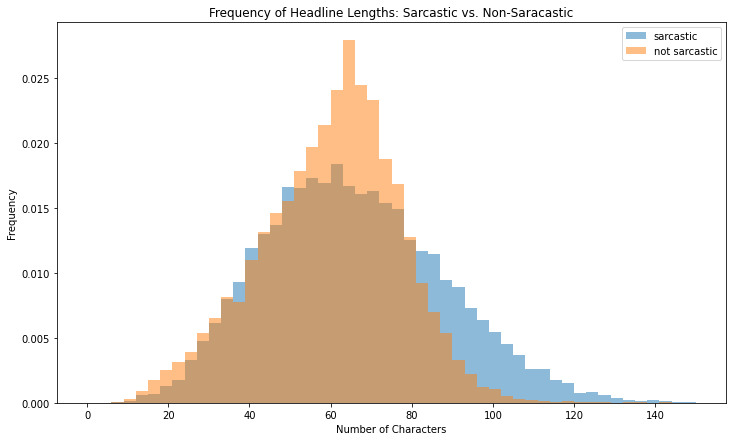

In [37]:
d_sar = data[data['label']=='sarcastic']
d_nsar = data[data['label']=='not sarcastic']

plt.figure(figsize=(12,7))
plt.hist(d_sar['length'], bins=50, alpha=0.5, label="sarcastic", range=(0,150),density = True)
plt.hist(d_nsar['length'], bins=50, alpha=0.5, label="not sarcastic", range = (0,150), density = True)
plt.xlabel("Number of Characters")
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title("Frequency of Headline Lengths: Sarcastic vs. Non-Saracastic")
plt.show()

### ... The sarcastic and non-sarcastic headlines in the raw data are distributed differently. Additionally, all sarcastic headlines are pulled from 'The Onion', where as all non-sarcastic headlines are pulled from 'Huffington Post'. In other words, it may be more accurate to say that this model is trained to detect which of the two publications a headline comes from. It's entirely possible that the writers at Huffington Post have a fundamentally different way of structuring sentences that has nothing to do with sarcasm/non-sarcasm.

### Lastly, just for the puropses of speculation, here is a sample of headlines from the dataset, along with their predicted labels and actual labels.

In [38]:
import random

pred = list(y_pred_test)
data_test['predictions'] = pred

count = 0
false_positive = 0
false_negative = 0
incorrect = []
correct = []
for [predicted, true, sentence] in zip(data_test.predictions, data_test.is_sarcastic, data_test.headline):
  if predicted == true:
    count += 1
    if predicted == 1:
      correct.append([sentence, 'predicted:  sarcastic', 'actual:     sarcastic'])
    else:
      correct.append([sentence, 'predicted:  not sarcastic', 'actual:     not sarcastic']) 
  else:
    if predicted == 1:
      incorrect.append([sentence, 'predicted:  sarcastic', 'actual:     not sarcastic'])
      false_positive += 1
    else:
      incorrect.append([sentence, 'predicted:  not sarcastic', 'actual:     sarcastic']) 
      false_negative += 1


randomlist_i = random.sample(range(len(incorrect)), 5)
randomlist_c = random.sample(range(len(correct)), 5)

print('Incorrect:')
for i in randomlist_i:
  entry = incorrect[i]
  print(entry[1])
  print(entry[2])
  print("\'" + str(entry[0]) + "\'")
  print('')

print('Correct:')
for c in randomlist_c:
  entry = correct[c]
  print(entry[1])
  print(entry[2])
  print("\'" + str(entry[0]) + "\'")
  print('')

Incorrect:
predicted:  sarcastic
actual:     not sarcastic
'equifax says another 2.4 million customers hit by data breach in 2017'

predicted:  not sarcastic
actual:     sarcastic
'doctors: cancer patients who watched the onion's amazon pilot daily showed signs of remission'

predicted:  sarcastic
actual:     not sarcastic
'4 high-level languages for front-end developers'

predicted:  sarcastic
actual:     not sarcastic
'jury awards ex-employee of roscoe's chicken n' waffles $1.6m in race discrimination suit'

predicted:  not sarcastic
actual:     sarcastic
'vp pick energizes republican basest'

Correct:
predicted:  not sarcastic
actual:     not sarcastic
'trump's 7 techniques to control the media'

predicted:  not sarcastic
actual:     not sarcastic
'how not to defend the humanities'

predicted:  not sarcastic
actual:     not sarcastic
'can we bring a glimmer of hope to syrians?'

predicted:  sarcastic
actual:     sarcastic
'embarrassed alexandria ocasio-cortez can only afford america

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# -- END --